In [1]:
import numpy as np
import os
import pathlib
import sys

if pathlib.Path(os.getcwd()).parents[2] not in sys.path:
    sys.path.append(str(pathlib.Path(os.getcwd()).parents[2]))

from Sensors.BatEcho.Spatializer import Render
from Sensors.BatEcho import Setting as sensorconfig
from Gym.BeaconDocking_v0 import Helper
from Arena import Builder

from Control.SensorimotorLoops.BatEcho import AvoidApproach
from Simulation.Motion import State
from Control.SensorimotorLoops import Setting as controlconfig

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
data = np.load('data.npz')
reference_poses = data['poses']
reference_scores= data['scores']
poses_matrix_reference = reference_poses[reference_scores==1]
beacon_centric_reference = np.copy(poses_matrix_reference)
theta = np.pi*(-0.5)
rotmat = np.asarray([np.cos(theta), -np.sin(theta), np.sin(theta), np.cos(theta)], dtype=np.float32).reshape(2,2)
beacon_centric_reference[:,:2] = np.matmul(rotmat, beacon_centric_reference[:,:2].T).T
beacon_centric_reference[:,2] = Builder.wrap2pi(beacon_centric_reference[:,2] + theta)

In [ ]:
fig, ax = plt.subplots(dpi=150)

ax.scatter(poses_matrix_reference[:,0],poses_matrix_reference[:,1], c='r', s=1, alpha=0.01)
ax.quiver(poses_matrix_reference[:,0],poses_matrix_reference[:,1],
        np.cos(poses_matrix_reference[:,2]), np.sin(poses_matrix_reference[:,2]),
          scale=25, width=3e-3, color='r', alpha=0.2)

ax.scatter(beacon_centric_reference[:,0],beacon_centric_reference[:,1], c='k', s=1, alpha=0.01)
ax.quiver(beacon_centric_reference[:,0],beacon_centric_reference[:,1],
        np.cos(beacon_centric_reference[:,2]), np.sin(beacon_centric_reference[:,2]),
          scale=25, width=3e-3, color='k', alpha=0.2)

#ax.scatter(objects[objects[:,2]==2][:,0], objects[objects[:,2]==2][:,1], c='g', s=150)
#ax.scatter(objects[objects[:,2]==1][:,0], objects[objects[:,2]==1][:,1], c='k', s=30)
#ax.set_xlim([-2.6,2.6])
#ax.set_ylim([-5,0.])
ax.set_aspect('equal')

In [ ]:
from mpl_toolkits import mplot3d

%matplotlib widget

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(beacon_centric_reference[:,0], beacon_centric_reference[:,1], np.degrees(beacon_centric_reference[:,2]), c=beacon_centric_reference[:,2], marker='s', s=25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('yaw')
ax.set_ylim([-4, 4])
ax.set_xlim([-7, 1])

In [2]:
%matplotlib inline

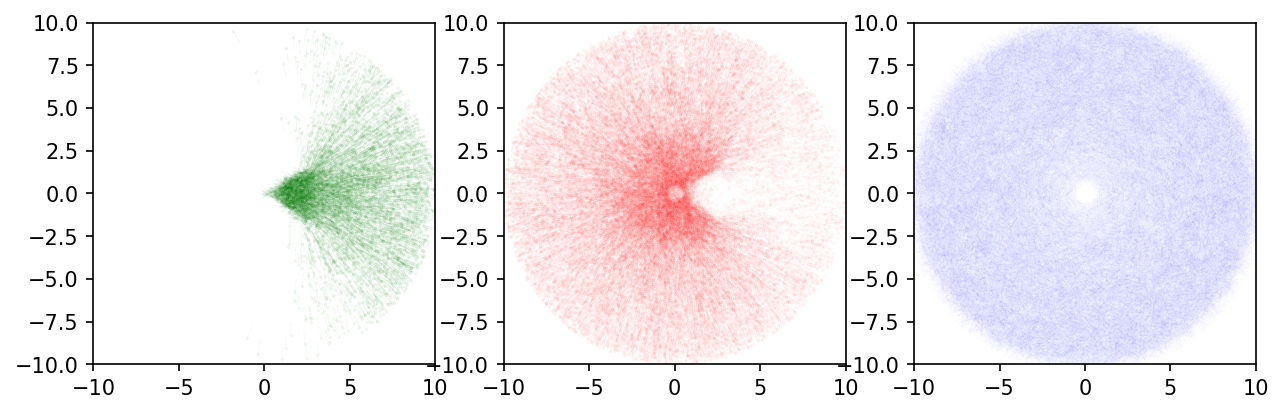

In [20]:
dataset = np.load('dockingZone_dataset.npz')
X = dataset['X']
Y= dataset['Y'].squeeze()
X_doc = X[Y==1]
X_hit = X[Y==-1]
X_out = X[Y==0]
X_out = X_out[np.where((X_out[:,0]!=0)+(X_out[:,1]!=0)+(X_out[:,2]!=0))][:100000]

fig, ax = plt.subplots(1,3,dpi=150, figsize=(10,30))
ax[0].scatter(X_doc[:,0],X_doc[:,1], c='g', s=0.1, alpha=0.1)
ax[0].quiver(X_doc[:,0],X_doc[:,1], np.cos(X_doc[:,2]), np.sin(X_doc[:,2]),
          scale=25, width=2e-3, color='g', alpha=0.05)
ax[1].scatter(X_hit[:,0],X_hit[:,1], c='r', s=0.1, alpha=0.05)
ax[1].quiver(X_hit[:,0],X_hit[:,1], np.cos(X_hit[:,2]), np.sin(X_hit[:,2]),
          scale=25, width=2e-3, color='r', alpha=0.02)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[2].quiver(X_out[:,0],X_out[:,1], np.cos(X_out[:,2]), np.sin(X_out[:,2]),
          scale=25, width=2e-3, color='b', alpha=0.01)

for a in ax:
    a.set_xlim([-10, 10])
    a.set_ylim([-10, 10])
    a.set_aspect('equal')


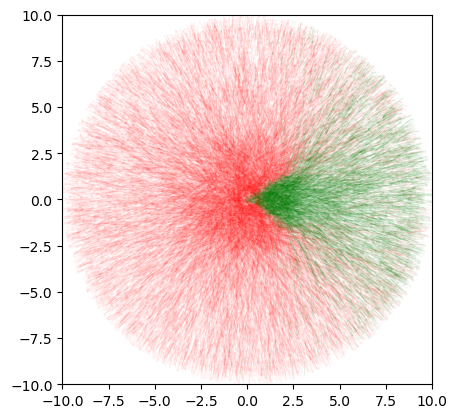

In [21]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(X_hit[:,0],X_hit[:,1], c='r', s=0.1, alpha=0.05)
ax.quiver(X_hit[:,0],X_hit[:,1], np.cos(X_hit[:,2]), np.sin(X_hit[:,2]),
          scale=25, width=2e-3, color='r', alpha=0.05)
ax.scatter(X_doc[:,0],X_doc[:,1], c='g', s=0.1, alpha=0.1)
ax.quiver(X_doc[:,0],X_doc[:,1], np.cos(X_doc[:,2]), np.sin(X_doc[:,2]),
          scale=25, width=2e-3, color='g', alpha=0.1)
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_aspect('equal')

In [22]:
N_hit = len(X_hit)
N_doc = len(X_doc)
N_out = len(X_out)
N_hit_percent = N_hit / (N_hit+N_doc+N_out)
N_doc_percent = N_doc / (N_hit+N_doc+N_out)
N_out_percent = N_out / (N_hit+N_doc+N_out)
print('Number of sample: [docked]={0} | [hit]={1} | [out]={2}'.format(N_doc, N_hit, N_out))
print('Class percentage: [docked]={:.2f} | [hit]={:.2f} | [out]={:.2f}'.format(N_doc_percent, N_hit_percent, N_out_percent))


Number of sample: [docked]=5659 | [hit]=29421 | [out]=100000
Class percentage: [docked]=0.04 | [hit]=0.22 | [out]=0.74


In [23]:
%matplotlib inline

### To learn or not to learn
I think I should construct a train and test dataset. From this cloud.
Aparently, KNClassifier seems the most intuitive for me. However, the disadvantage is the with a large cloud of data. It will be very expensive to during runtime.
-> Let's use KNClassifier as a benchmark
Test a few candidate:
0. KNClassifer (benchmark)
1. Logistic Regression.
2. RBF SVM
3. Gaussian Process --> Do Not Compute!
4. Naive Bayes (Gaussian, Bernoulli, Categorical)

!!! Metrics:
1. Test Accuracy
2. Precision Recall
* Precision = TP/(TP + FP)
* Recall = TP/(TP + FN)
* ROC (receiver operating characteristic curve) curve (TP_rate vs FP_rate):
  * TP_rate = recall = TP/(TP+FN)
  * FP_rate = FP/(FP+TN)
  * Each point on the curve is for a threshold (or decision threshold)
  * Are under this curve indicate performance of a method despite thresholding.
* Precision recall curve: Area under this curve indicate performance.


### Metrics Functions

In [24]:
def getMetrics(Y_hat, Y, classes):
    metrics = {}
    metrics['accuracy'] = np.sum(Y_hat==Y) / len(Y_hat)
    n_class = len(classes)
    TP, FP, TN, FN = np.zeros(n_class), np.zeros(n_class), np.zeros(n_class), np.zeros(n_class)
    for i, k in enumerate(classes):
        TP[i] = np.sum(Y_hat[Y_hat==k] == Y[Y_hat==k])
        FP[i] = np.sum(Y_hat[Y_hat==k] != Y[Y_hat==k])
        TN[i] = np.sum(Y[Y_hat!=k] != k)
        FN[i] = np.sum(Y[Y_hat!=k] == k)
    metrics['precision'] = np.divide(TP, TP+FP)
    metrics['recall'] = np.divide(TP, TP+FN)
    metrics['FP_rate'] = np.divide(FP, FP+TN)
    return metrics

In [25]:
X_set = np.vstack((X_doc, X_hit, X_out))
Y_set = np.vstack((0*np.ones((len(X_doc),1)), 1*np.ones((len(X_hit),1)), 2*np.ones((len(X_out),1)) ))
labels = {'doc': 0, 'hit': 1, 'out': 2}

Train Size = 108064 | Test Size = 27016


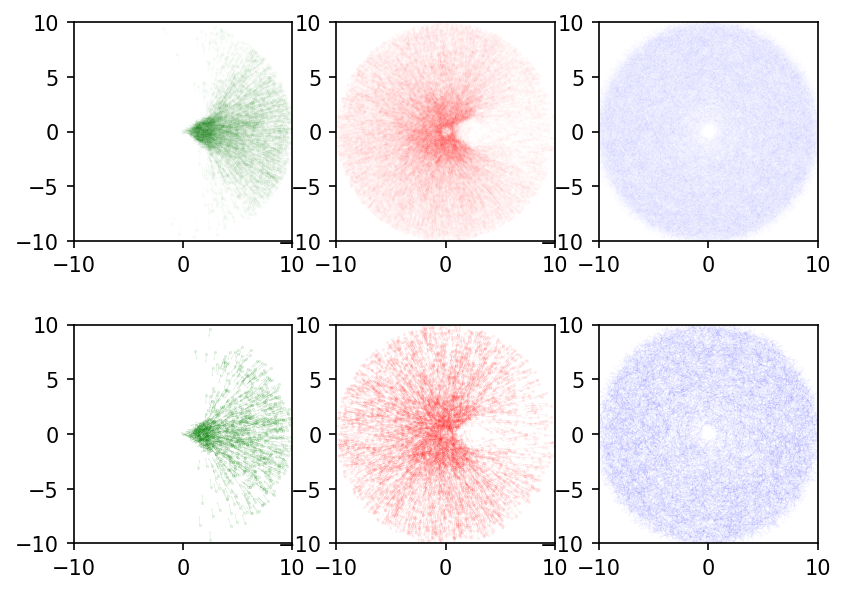

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_set, Y_set.squeeze(), test_size=0.2, random_state=123)
print('Train Size = {0} | Test Size = {1}'.format(len(X_train), len(X_test)))

fig, ax = plt.subplots(2,3,dpi=150)
ax[0,0].scatter(X_train[y_train==0][:,0],X_train[y_train==0][:,1], c='g', s=0.1, alpha=0.05)
ax[0,0].quiver(X_train[y_train==0][:,0],X_train[y_train==0][:,1], np.cos(X_train[y_train==0][:,2]), np.sin(X_train[y_train==0][:,2]),
          scale=25, width=2e-3, color='g', alpha=0.05)
ax[0,1].scatter(X_train[y_train==1][:,0],X_train[y_train==1][:,1], c='r', s=0.1, alpha=0.02)
ax[0,1].quiver(X_train[y_train==1][:,0],X_train[y_train==1][:,1], np.cos(X_train[y_train==1][:,2]), np.sin(X_train[y_train==1][:,2]),
          scale=25, width=2e-3, color='r', alpha=0.02)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[0,2].quiver(X_train[y_train==2][:,0],X_train[y_train==2][:,1], np.cos(X_train[y_train==2][:,2]), np.sin(X_train[y_train==2][:,2]),
          scale=25, width=2e-3, color='b', alpha=0.01)

ax[1,0].scatter(X_test[y_test==0][:,0],X_test[y_test==0][:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_test[y_test==0][:,0],X_test[y_test==0][:,1], np.cos(X_test[y_test==0][:,2]), np.sin(X_test[y_test==0][:,2]),
          scale=25, width=2e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_test[y_test==1][:,0],X_test[y_test==1][:,1], c='r', s=0.1, alpha=0.1)
ax[1,1].quiver(X_test[y_test==1][:,0],X_test[y_test==1][:,1], np.cos(X_test[y_test==1][:,2]), np.sin(X_test[y_test==1][:,2]),
          scale=25, width=2e-3, color='r', alpha=0.1)
#ax[2].scatter(X_out[:,0],X_out[:,1], c='b', s=0.1, alpha=0.01)
ax[1,2].quiver(X_test[y_test==2][:,0],X_test[y_test==2][:,1], np.cos(X_test[y_test==2][:,2]), np.sin(X_test[y_test==2][:,2]),
          scale=25, width=2e-3, color='b', alpha=0.05)

for i in range(len(ax)):
    for axx in ax[i]:
        axx.set_xlim([-10, 10])
        axx.set_ylim([-10, 10])
        axx.set_aspect('equal')


### KNN Classifier

In [27]:
from sklearn.neighbors import KNeighborsClassifier
KNC_metrics={}
for k in range(3,13):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    KNC_metrics[k]=getMetrics(prediction, y_test, classes=list(labels.values()))

In [28]:
avg_accuracy = 0
for metrics, k in zip(KNC_metrics.values(),KNC_metrics.keys()):
    print('N_neighbor={:}, accuracy={:.2f}, precision={:}, recall={:}'.format(k,metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(KNC_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

N_neighbor=3, accuracy=0.94, precision=[0.73 0.87 0.98], recall=[0.78 0.91 0.96]
N_neighbor=4, accuracy=0.94, precision=[0.72 0.85 0.99], recall=[0.83 0.94 0.95]
N_neighbor=5, accuracy=0.94, precision=[0.74 0.86 0.98], recall=[0.81 0.93 0.96]
N_neighbor=6, accuracy=0.94, precision=[0.72 0.85 0.99], recall=[0.82 0.94 0.95]
N_neighbor=7, accuracy=0.95, precision=[0.75 0.86 0.99], recall=[0.81 0.93 0.96]
N_neighbor=8, accuracy=0.94, precision=[0.73 0.85 0.99], recall=[0.83 0.94 0.95]
N_neighbor=9, accuracy=0.95, precision=[0.74 0.86 0.99], recall=[0.81 0.94 0.95]
N_neighbor=10, accuracy=0.94, precision=[0.74 0.85 0.99], recall=[0.83 0.95 0.95]
N_neighbor=11, accuracy=0.95, precision=[0.74 0.86 0.99], recall=[0.82 0.94 0.95]
N_neighbor=12, accuracy=0.94, precision=[0.74 0.84 0.99], recall=[0.82 0.95 0.95]
Accuracy = 0.94


### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
LogReg_metrics = {}
for C in [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]:
    model = LogisticRegression(C=C)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    LogReg_metrics[C] = getMetrics(prediction, y_test, classes=list(labels.values()))

<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7

In [30]:
avg_accuracy = 0
for metrics, k in zip(LogReg_metrics.values(),LogReg_metrics.keys()):
    #print('C={:}, accuracy={:.2f}'.format(k, metrics['accuracy']))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(LogReg_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

Accuracy = 0.74


### Support Vector Machine

In [31]:
from sklearn import svm
gammas = [0.1, 0.3, 0.6, 1, 3, 6, 10]
Cs = [1e-2, 1e-1, 1, 1e1, 1e2]
SVM_metrics = {}
for g in gammas:
    for c in Cs:
        model = svm.SVC(kernel='rbf', C=c, gamma=g)
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        SVM_metrics[(c,g)] = getMetrics(prediction, y_test, classes=list(labels.values()))

<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)


In [32]:
avg_accuracy = 0
for metrics, k in zip(SVM_metrics.values(),SVM_metrics.keys()):
    if (metrics['accuracy']<0.9) or (metrics['precision'][0]<0.9): continue
    print('C={:.1f}, gamma={:.1f}, accuracy={:.2f}, precision={:}, recall={:}'.format(k[0],k[1],metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(SVM_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

C=0.1, gamma=10.0, accuracy=0.91, precision=[0.96 0.96 0.9 ], recall=[0.38 0.73 0.99]
Accuracy = 0.03


### Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB

NB_metrics = {}
classifiers = {'gaussian': GaussianNB(),
                  'bernoulli': BernoulliNB()}
for key, model in zip(classifiers.keys(), classifiers.values()):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    NB_metrics[key] = getMetrics(prediction, y_test, classes=list(labels.values()))

<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)
<ipython-input-24-083d510c7629>:11: RuntimeWarning: invalid value encountered in true_divide
  metrics['precision'] = np.divide(TP, TP+FP)


In [34]:
avg_accuracy = 0
for metrics, k in zip(NB_metrics.values(),NB_metrics.keys()):
    print('mode='+k+', accuracy={:.2f}'.format(metrics['accuracy']))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(NB_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

mode=gaussian, accuracy=0.74
mode=bernoulli, accuracy=0.74
Accuracy = 0.74


### Neural Network

In [35]:
from sklearn.neural_network import MLPClassifier
hidden_sets = [(4,), (8,), (16,) , (32,),
               (4,4),   (8,8),   (16, 16),
               (4,4,4), (8,8,8), (16, 16, 16)]
NeuNet_metrics = {}
for hidden in hidden_sets:
    model = MLPClassifier(hidden_layer_sizes=hidden, max_iter=100_000)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    NeuNet_metrics[hidden] = getMetrics(prediction, y_test, classes=list(labels.values()))


In [36]:
avg_accuracy = 0
for metrics, k in zip(NeuNet_metrics.values(),NeuNet_metrics.keys()):
    print('hidden='+str(k)+', accuracy={:.2f}, precision={:}, recall={:}'.format(metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(NeuNet_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

hidden=(4,), accuracy=0.80, precision=[0.57 0.69 0.82], recall=[0.17 0.43 0.95]
hidden=(8,), accuracy=0.90, precision=[0.55 0.77 0.96], recall=[0.55 0.84 0.94]
hidden=(16,), accuracy=0.92, precision=[0.64 0.83 0.96], recall=[0.67 0.86 0.95]
hidden=(32,), accuracy=0.95, precision=[0.79 0.87 0.98], recall=[0.71 0.93 0.97]
hidden=(4, 4), accuracy=0.88, precision=[0.59 0.71 0.95], recall=[0.27 0.83 0.93]
hidden=(8, 8), accuracy=0.95, precision=[0.75 0.88 0.98], recall=[0.79 0.91 0.97]
hidden=(16, 16), accuracy=0.95, precision=[0.83 0.88 0.98], recall=[0.75 0.94 0.97]
hidden=(4, 4, 4), accuracy=0.90, precision=[0.58 0.79 0.95], recall=[0.64 0.78 0.94]
hidden=(8, 8, 8), accuracy=0.95, precision=[0.78 0.88 0.98], recall=[0.74 0.93 0.97]
hidden=(16, 16, 16), accuracy=0.96, precision=[0.81 0.9  0.98], recall=[0.83 0.94 0.97]
Accuracy = 0.91


## Result
### Select SVM RBF for classifier
### Papermeter:
C=10, Gamma=1 -> balance Precision Recall
### Emphasize on Precision but low recall
C=0.1, gamma=6.0, accuracy=0.93, precision=[0.96 0.94 0.93], recall=[0.59 0.89 0.99]
Accuracy = 0.03

In [39]:
from sklearn import svm
model1svm = svm.SVC(kernel='rbf', C=10., gamma=0.3)
model1svm.fit(X_train, y_train)
prediction1svm = model1svm.predict(X_test)

model2svm = svm.SVC(kernel='rbf', C=0.1, gamma=3.)
model2svm.fit(X_train, y_train)
prediction2svm = model2svm.predict(X_test)

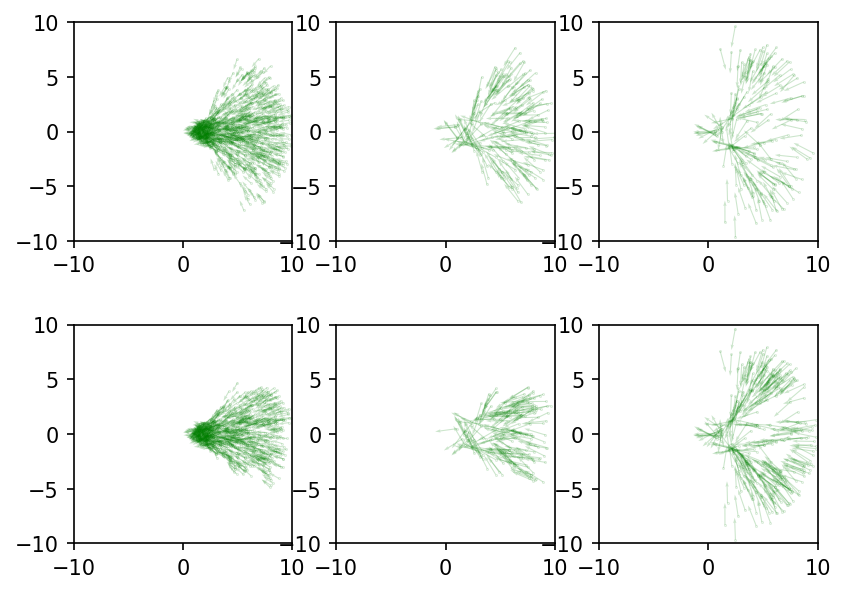

In [40]:
fig, ax = plt.subplots(2,3, dpi=150)
label = 0
# Plot True Positive
X_TP1 = X_test[(prediction1svm==label) * (y_test==label)]
X_TP2 = X_test[(prediction2svm==label) * (y_test==label)]
ax[0,0].scatter(X_TP1[:,0],X_TP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,0].quiver(X_TP1[:,0],X_TP1[:,1], np.cos(X_TP1[:,2]), np.sin(X_TP1[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)
ax[1,0].scatter(X_TP2[:,0],X_TP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_TP2[:,0],X_TP2[:,1], np.cos(X_TP2[:,2]), np.sin(X_TP2[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)

# Plot False Positive
X_FP1 = X_test[(prediction1svm==label) * (y_test!=label)]
X_FP2 = X_test[(prediction2svm==label) * (y_test!=label)]
ax[0,1].scatter(X_FP1[:,0],X_FP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,1].quiver(X_FP1[:,0],X_FP1[:,1], np.cos(X_FP1[:,2]), np.sin(X_FP1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_FP2[:,0],X_FP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,1].quiver(X_FP2[:,0],X_FP2[:,1], np.cos(X_FP2[:,2]), np.sin(X_FP2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

# Plot False Negative
X_FN1 = X_test[(prediction1svm!=label) * (y_test==label)]
X_FN2 = X_test[(prediction2svm!=label) * (y_test==label)]
ax[0,2].scatter(X_FN1[:,0],X_FN1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,2].quiver(X_FN1[:,0],X_FN1[:,1], np.cos(X_FN1[:,2]), np.sin(X_FN1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,2].scatter(X_FN2[:,0],X_FN2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,2].quiver(X_FN2[:,0],X_FN2[:,1], np.cos(X_FN2[:,2]), np.sin(X_FN2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

for i in range(6):
    ax[int(i/3), i%3].set_xlim([-10,10])
    ax[int(i/3), i%3].set_ylim([-10,10])
    ax[int(i/3), i%3].set_aspect('equal')
    

In [43]:
from joblib import dump
dump (model1svm, 'dockingZone_classifier_SVM.joblib')

['dockingZone_classifier_SVM.joblib']

In [48]:
def generate_confusion_matrix(model, X_test, Y_test):
    import time
    avg_inference_time = 0
    for i in range(10):
        tic = time.time()
        _ = model.predict(X_test[i].reshape(1,-1))
        inference_time = time.time() - tic
        avg_inference_time += inference_time
    avg_inference_time /= 10
    
    Y_predict = model.predict(X_test)
    # generate confusion matrix for each class 0, 1, 2 without using a loop
    confusion_matrix = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            confusion_matrix[i,j] = np.sum((Y_predict==i) * (Y_test==j))

    return confusion_matrix, avg_inference_time

In [49]:
model1svm_confusion_matrix, model1svm_avg_inference_time = generate_confusion_matrix(model1svm, X_test, y_test)
print(model1svm_confusion_matrix)
print('Average inference time = {:.2f} ms'.format(model1svm_avg_inference_time*1000))

[[  950.   121.   105.]
 [  157.  5647.   565.]
 [   39.   157. 19275.]]
Average inference time = 0.48 ms


In [51]:
print('number of docked: ', np.sum(y_test==0))
print('number of hit:    ', np.sum(y_test==1))
print('number of miss:   ', np.sum(y_test==2))

number of docked:  1146
number of hit:     5925
number of miss:    19945


In [52]:
from sklearn.neural_network import MLPClassifier
hidden_sets = [(8,8),   (16, 16)]
NeuNet_metrics = {}
models = []
predictions = []
for hidden in hidden_sets:
    model = MLPClassifier(hidden_layer_sizes=hidden, max_iter=100_000)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    NeuNet_metrics[hidden] = getMetrics(prediction, y_test, classes=list(labels.values()))
    models.append(model)
    predictions.append(prediction)

model1, model2 = models
prediction1, prediction2 = predictions

In [53]:
avg_accuracy = 0
for metrics, k in zip(NeuNet_metrics.values(),NeuNet_metrics.keys()):
    print('hidden='+str(k)+', accuracy={:.2f}, precision={:}, recall={:}'.format(metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(NeuNet_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))

hidden=(8, 8), accuracy=0.94, precision=[0.74 0.89 0.97], recall=[0.74 0.89 0.97]
hidden=(16, 16), accuracy=0.96, precision=[0.79 0.9  0.98], recall=[0.82 0.93 0.97]
Accuracy = 0.95


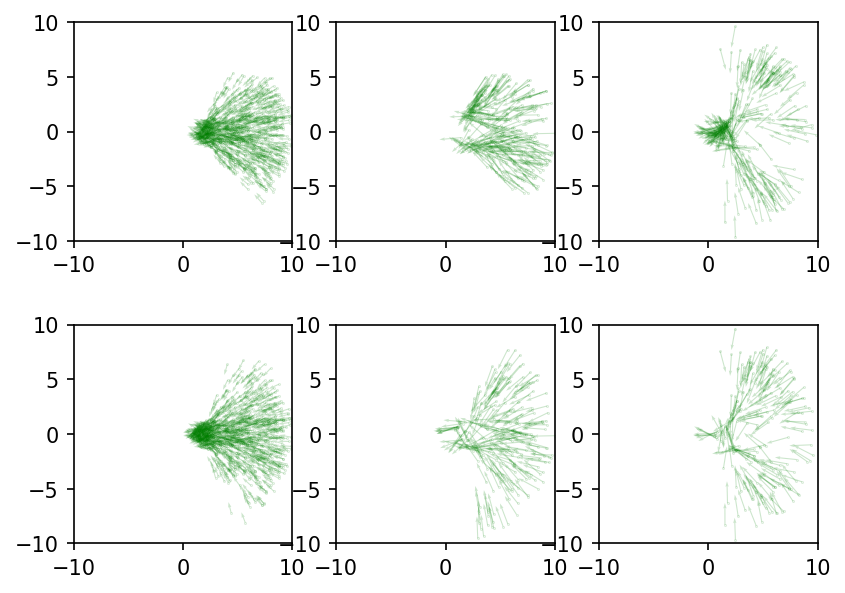

In [54]:
fig, ax = plt.subplots(2,3, dpi=150)
label = 0
# Plot True Positive
X_TP1 = X_test[(prediction1==label) * (y_test==label)]
X_TP2 = X_test[(prediction2==label) * (y_test==label)]
ax[0,0].scatter(X_TP1[:,0],X_TP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,0].quiver(X_TP1[:,0],X_TP1[:,1], np.cos(X_TP1[:,2]), np.sin(X_TP1[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)
ax[1,0].scatter(X_TP2[:,0],X_TP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_TP2[:,0],X_TP2[:,1], np.cos(X_TP2[:,2]), np.sin(X_TP2[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)

# Plot False Positive
X_FP1 = X_test[(prediction1==label) * (y_test!=label)]
X_FP2 = X_test[(prediction2==label) * (y_test!=label)]
ax[0,1].scatter(X_FP1[:,0],X_FP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,1].quiver(X_FP1[:,0],X_FP1[:,1], np.cos(X_FP1[:,2]), np.sin(X_FP1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_FP2[:,0],X_FP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,1].quiver(X_FP2[:,0],X_FP2[:,1], np.cos(X_FP2[:,2]), np.sin(X_FP2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

# Plot False Negative
X_FN1 = X_test[(prediction1!=label) * (y_test==label)]
X_FN2 = X_test[(prediction2!=label) * (y_test==label)]
ax[0,2].scatter(X_FN1[:,0],X_FN1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,2].quiver(X_FN1[:,0],X_FN1[:,1], np.cos(X_FN1[:,2]), np.sin(X_FN1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,2].scatter(X_FN2[:,0],X_FN2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,2].quiver(X_FN2[:,0],X_FN2[:,1], np.cos(X_FN2[:,2]), np.sin(X_FN2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

for i in range(6):
    ax[int(i/3), i%3].set_xlim([-10,10])
    ax[int(i/3), i%3].set_ylim([-10,10])
    ax[int(i/3), i%3].set_aspect('equal')
    

In [56]:
model1mlp_confusion_matrix, model1mlp_avg_inference_time = generate_confusion_matrix(model2, X_test, y_test)
print(model1mlp_confusion_matrix)
print('Average inference time = {:.2f} ms'.format(model1mlp_avg_inference_time*1000))
print('number of docked: ', np.sum(y_test==0))
print('number of hit:    ', np.sum(y_test==1))
print('number of miss:   ', np.sum(y_test==2))

[[  942.   152.    91.]
 [  138.  5498.   492.]
 [   66.   275. 19362.]]
Average inference time = 0.11 ms
number of docked:  1146
number of hit:     5925
number of miss:    19945


In [57]:
from joblib import dump
dump (model2, 'dockingZone_classifier_MLP.joblib')

['dockingZone_classifier_MLP.joblib']

In [58]:
from sklearn.neighbors import KNeighborsClassifier

KNC_metrics={}
k_sets = [3, 7]
models_knn = []
predictions_knn = []
for k in k_sets:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    KNC_metrics[k]=getMetrics(prediction, y_test, classes=list(labels.values()))
    models_knn.append(model)
    predictions_knn.append(prediction)

avg_accuracy = 0
for metrics, k in zip(KNC_metrics.values(),KNC_metrics.keys()):
    print('N_neighbor={:}, accuracy={:.2f}, precision={:}, recall={:}'.format(k,metrics['accuracy'],np.round(metrics['precision'],2),np.round(metrics['recall'],2)))
    avg_accuracy+=metrics['accuracy']
avg_accuracy /= len(KNC_metrics.keys())
print('Accuracy = {:.2f}'.format(avg_accuracy))


N_neighbor=3, accuracy=0.94, precision=[0.73 0.87 0.98], recall=[0.78 0.91 0.96]
N_neighbor=7, accuracy=0.95, precision=[0.75 0.86 0.99], recall=[0.81 0.93 0.96]
Accuracy = 0.94


In [59]:
model1knn, model2knn = models_knn
prediction1knn, prediction2knn = predictions_knn

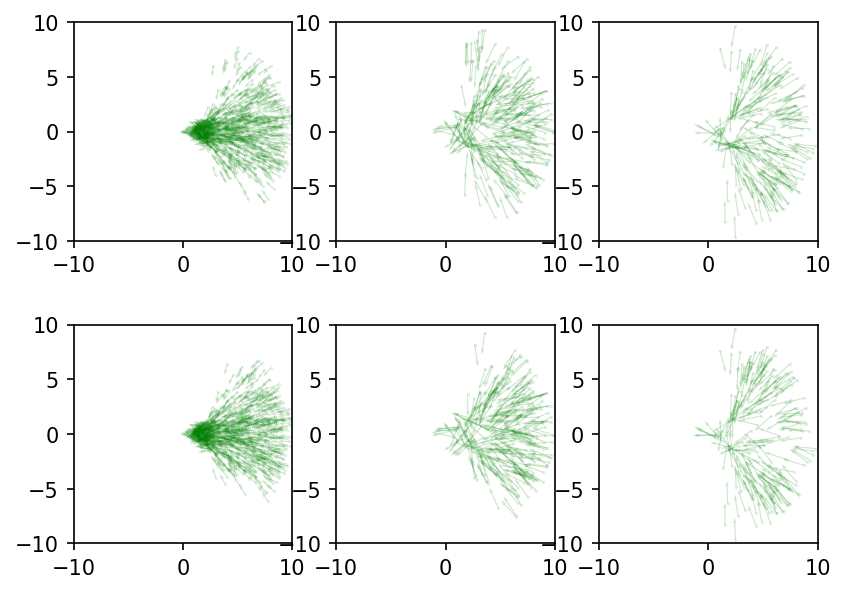

In [60]:
fig, ax = plt.subplots(2,3, dpi=150)
label = 0
# Plot True Positive
X_TP1 = X_test[(prediction1knn==label) * (y_test==label)]
X_TP2 = X_test[(prediction2knn==label) * (y_test==label)]
ax[0,0].scatter(X_TP1[:,0],X_TP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,0].quiver(X_TP1[:,0],X_TP1[:,1], np.cos(X_TP1[:,2]), np.sin(X_TP1[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)
ax[1,0].scatter(X_TP2[:,0],X_TP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,0].quiver(X_TP2[:,0],X_TP2[:,1], np.cos(X_TP2[:,2]), np.sin(X_TP2[:,2]),
          scale=20, width=5e-3, color='g', alpha=0.2)

# Plot False Positive
X_FP1 = X_test[(prediction1knn==label) * (y_test!=label)]
X_FP2 = X_test[(prediction2knn==label) * (y_test!=label)]
ax[0,1].scatter(X_FP1[:,0],X_FP1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,1].quiver(X_FP1[:,0],X_FP1[:,1], np.cos(X_FP1[:,2]), np.sin(X_FP1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,1].scatter(X_FP2[:,0],X_FP2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,1].quiver(X_FP2[:,0],X_FP2[:,1], np.cos(X_FP2[:,2]), np.sin(X_FP2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

# Plot False Negative
X_FN1 = X_test[(prediction1knn!=label) * (y_test==label)]
X_FN2 = X_test[(prediction2knn!=label) * (y_test==label)]
ax[0,2].scatter(X_FN1[:,0],X_FN1[:,1], c='g', s=0.1, alpha=0.2)
ax[0,2].quiver(X_FN1[:,0],X_FN1[:,1], np.cos(X_FN1[:,2]), np.sin(X_FN1[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)
ax[1,2].scatter(X_FN2[:,0],X_FN2[:,1], c='g', s=0.1, alpha=0.2)
ax[1,2].quiver(X_FN2[:,0],X_FN2[:,1], np.cos(X_FN2[:,2]), np.sin(X_FN2[:,2]),
          scale=10, width=5e-3, color='g', alpha=0.2)

for i in range(6):
    ax[int(i/3), i%3].set_xlim([-10,10])
    ax[int(i/3), i%3].set_ylim([-10,10])
    ax[int(i/3), i%3].set_aspect('equal')
    

In [66]:
knn_confusion_matrix, knn_avg_inference_time = generate_confusion_matrix(model2knn, X_test, y_test)
print(knn_confusion_matrix)
print('Average inference time = {:.2f} ms'.format(knn_avg_inference_time*1000))
print('number of docked: ', np.sum(y_test==0))
print('number of hit:    ', np.sum(y_test==1))
print('number of miss:   ', np.sum(y_test==2))

[[  924.   181.   134.]
 [  170.  5535.   728.]
 [   52.   209. 19083.]]
Average inference time = 0.43 ms
number of docked:  1146
number of hit:     5925
number of miss:    19945


In [ ]:
from joblib import dump
dump (model1, 'dockingZone_classifier.joblib')